# Results from Adversarial RadioML

This notebook summarizes the results from adversarial attacks against the RadioML dataset. The result logger class in `arml/performances.py` has the performances for the accuracy, AUC and perplexity. 

In [1]:
import pickle 
import matplotlib.pylab as plt
plt.style.use('bmh')

# FastGradientMethod Epsilon Variation 

In [2]:
acc_benign = {-20: 0.09252217997465145,
 -18: 0.0961057520543051,
 -16: 0.10349854227405247,
 -14: 0.11773203322499097,
 -12: 0.14853131350452614,
 -10: 0.21736775591261961,
 -8: 0.33466642428649335,
 -6: 0.4909090909090909,
 -4: 0.6302121433796635,
 -2: 0.7135369600578348,
 0: 0.75758129338692,
 2: 0.7774513404333456,
 4: 0.7940644227289179,
 6: 0.7858455882352942,
 8: 0.7968806673920928,
 10: 0.7866857551896922,
 12: 0.784231609613984,
 14: 0.7975528364849833,
 16: 0.787350054525627,
 18: 0.7894260365743255}

In [3]:
cd G:\My Drive\Git\radioml-exp\

G:\My Drive\Git\radioml-exp


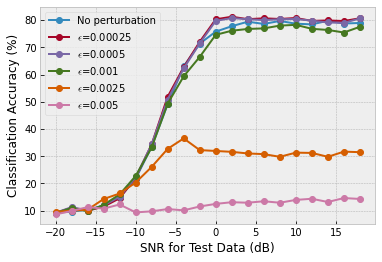

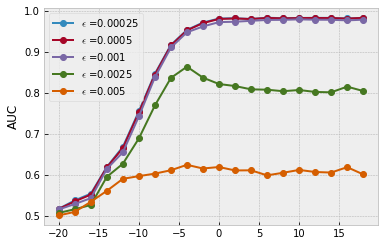

In [4]:
data = pickle.load(open('outputs/vtcnn2_FGSM_wb_1fold_shift100_op.pkl', 'rb'))
logger = data['result_logger']

plt.figure()
plt.plot(logger.snrs, list(map(lambda x: 100*acc_benign[x], logger.snrs)), marker='o', label= 'No perturbation')
for i, eps in enumerate(logger.epsilons): 
    plt.plot(logger.snrs, 100*logger.accuracy[:, i], marker='o', label=''.join(['$\epsilon$=', str(eps)]))
plt.legend()
plt.ylabel('Classification Accuracy (%)')
plt.xlabel('SNR for Test Data (dB)')
plt.savefig('outputs/fgsm_1fold_shift100_accuracy_epsilons.pdf')

plt.figure()
for i, eps in enumerate(logger.epsilons): 
    plt.plot(logger.snrs, logger.aucs[:, i], marker='o', label=''.join(['$\epsilon$ =', str(eps)]))
plt.legend()
plt.ylabel('AUC')
plt.savefig('outputs/fgsm_1fold_shift100_auc_epsilons.pdf')

In [3]:
! tensorboard --logdir logs/fit

^C


In [3]:
import tensorflow as tf
from tensorflow import keras 

In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
# read the saved weights from the recordings
reconstructed_model = keras.models.load_model("FGSM_CNN2_1fold.wts.h5")

In [6]:
from arml import utils

In [7]:
X, Y, snrs, mods, _ = utils.load_radioml(file_path='data/RML2016.10a_dict.pkl', shuffle=True)

In [8]:
import numpy as np

In [9]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

In [10]:
Y_arg = np.argmax(Y,axis = 1)

In [11]:
Y_arg.shape

(220000,)

In [12]:
X_test = X[0:5000]

In [19]:
Y_test = Y[0:5000]

In [20]:
Y_test.shape

(5000, 11)

In [14]:
predictions = reconstructed_model.predict(X_test)

C:\Users\wenhanzhang\Anaconda3\envs\RML_2\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [21]:
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 58.620000000000005%


In [22]:
from art.attacks.evasion import FastGradientMethod

C:\Users\wenhanzhang\Anaconda3\envs\RML_2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\wenhanzhang\Anaconda3\envs\RML_2\lib\site-packages\art\estimators\certification\__init__.py:12: UserWarning: PyTorch not found. Not importing DeepZ functionality
  warnings.warn("PyTorch not found. Not importing DeepZ functionality")


In [24]:
from art.estimators.classification import KerasClassifier

In [25]:
classifier = KerasClassifier(model=reconstructed_model, clip_values=(-5.0, 5.0), use_logits=False)

In [26]:
attack = FastGradientMethod(estimator=classifier, 
                                    eps=0.005)

In [27]:
Xadv = attack.generate(x=X_test)

In [30]:
predictions_adv = classifier.predict(Xadv)

In [29]:
accuracy = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 11.52%


In [31]:
from art.defences.postprocessor import HighConfidence

In [32]:
preds = classifier.predict(X_test)
postprocessor = HighConfidence(cutoff=0.5)
post_preds = postprocessor(preds=preds)

In [36]:
preds[10]

array([3.1757593e-02, 4.2785226e-07, 1.3290304e-09, 2.3226824e-04,
       3.5684090e-04, 2.8132281e-05, 1.5493839e-06, 9.6568180e-04,
       3.6549848e-04, 9.6628720e-01, 4.7366361e-06], dtype=float32)

In [33]:
accuracy = np.sum(np.argmax(post_preds, axis=1) == np.argmax(Y_test, axis=1)) / len(Y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 49.26%


In [37]:
post_preds[10]

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.9662872, 0.       ],
      dtype=float32)